# Flowers Project

We want to train a model that can tell the difference between 5 types of Flowers

To do this we are going to use a famous Imagenet model called InceptionV3 to do transfer Learning.

Along the way will also use the new tf.data along with Pandas to handle the input pipelines for training and testing.

This project can be customized to a variety of different image datasets. Here ia another you could try:

Monkeys  - https://www.dropbox.com/s/je25ylpp8r1r8uc/10-monkey-species.zip


In [0]:
!ls

sample_data


## Testing for GPU 


To Test if you have GPU set up

Run the Cell below

if no GPU is found press Runtime (in the menu at the top) and choose "Change Runtime Type" to GPU

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Download the data

by placing ! infront we can run almost any linux shell command

In [1]:
!wget -qq https://www.dropbox.com/s/vj61417lofjebju/utils.zip
!wget -qq https://www.dropbox.com/s/pcv5wpk0ybsohib/flowers.zip
  
  
!unzip -qq flowers.zip
!rm flowers.zip

!unzip -qq utils.zip
!rm utils.zip


!ls

flowers  gdrive.py  __MACOSX  sample_data  sutils.py


In [2]:
!ls flowers

daisy  dandelion  rose	sunflower  tulip


In [0]:
!ls flowers/rose

10090824183_d02c613f10_m.jpg  4612833069_8e48b47aa4_n.jpg
102501987_3cdb8e5394_n.jpg    4625089819_55c45a189c.jpg
10503217854_e66a804309.jpg    4644336779_acd973528c.jpg
10894627425_ec76bbc757_n.jpg  4648680921_80dfc4f12a.jpg
110472418_87b6a3aa98_m.jpg    4654893119_45d232016b.jpg
11102341464_508d558dfc_n.jpg  466486216_ab13b55763.jpg
11233672494_d8bf0a3dbf_n.jpg  4675532860_890504a4a3_m.jpg
11694025703_9a906fedc1_n.jpg  4684127262_6c3346188d.jpg
118974357_0faa23cce9_n.jpg    4694341873_65fe187a4e_n.jpg
11944957684_2cc806276e.jpg    4702438868_278b9cf41c_n.jpg
12202373204_34fb07205b.jpg    4703837996_d3c1df77cc_n.jpg
12238827553_cf427bfd51_n.jpg  4713531680_1110a2fa07_n.jpg
12240165555_98625b1e88_n.jpg  4713533500_fcc295de70_n.jpg
12240303_80d87f77a3_n.jpg     4735314389_94fe1b2a9f_n.jpg
12240577184_b0de0e53ea_n.jpg  4754734410_94d98463a5.jpg
12243068283_ee4c2683e2_n.jpg  475947979_554062a608_m.jpg
12243069253_e512464095_n.jpg  4764674741_82b8f93359_n.jpg
123128873_546b8b7355_n.jpg    

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, json
from glob import glob
import numpy as np

import keras

from tensorflow.keras import optimizers

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback




In [7]:
print(tf.__version__)
print(tf.keras.__version__)
print(keras.__version__)

NameError: ignored

In [0]:


!ls flowers

daisy  dandelion  rose	sunflower  tulip


In [0]:
# Set up some Hyperparameters

batch_size = 32
epochs = 10

lr = 0.001

## Converting raw files in folders into something we can feed into tf.data

We use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.

We also then split them up so we have 10% for a testing set and the rest for training.

finally we randomly shuffle them up



In [9]:
import glob
import pandas as pd

filenames_n0 = glob.glob('./flowers/daisy/*.jpg')
filenames_n1 = glob.glob('./flowers/dandelion/*.jpg')
filenames_n2 = glob.glob('./flowers/rose/*.jpg')
filenames_n3 = glob.glob('./flowers/sunflower/*.jpg')
filenames_n4 = glob.glob('./flowers/tulip/*.jpg')

names = ['daisy', 'dandelion','rose','sunflower','tulip']


len(filenames_n1)


1024

In [0]:
filenames_n3[:10]

['./flowers/sunflower/5330608174_b49f7a4c48_m.jpg',
 './flowers/sunflower/20481273479_d459834a3e_n.jpg',
 './flowers/sunflower/14741812319_e1d32ffb84_n.jpg',
 './flowers/sunflower/12282924083_fb80aa17d4_n.jpg',
 './flowers/sunflower/15745084272_36402f5ee6_n.jpg',
 './flowers/sunflower/6953297_8576bf4ea3.jpg',
 './flowers/sunflower/3815322974_52c12dbde3.jpg',
 './flowers/sunflower/9302733302_2cb92cf275.jpg',
 './flowers/sunflower/5994572653_ea98afa3af_n.jpg',
 './flowers/sunflower/193874852_fb633d8d00_n.jpg']

In [10]:
# Make a dataframe based on the filenames
df = pd.DataFrame(filenames_n0, columns = ["filename"])
df2 = pd.DataFrame(filenames_n1, columns = ["filename"])
df3 = pd.DataFrame(filenames_n2, columns = ["filename"])
df4 = pd.DataFrame(filenames_n3, columns = ["filename"])
df5 = pd.DataFrame(filenames_n4, columns = ["filename"])

df.head()

,filename
0,./flowers/daisy/14698531521_0c2f0c6539.jpg
1,./flowers/daisy/107592979_aaa9cdfe78_m.jpg
2,./flowers/daisy/10172379554_b296050f82_n.jpg
3,./flowers/daisy/6323721068_3d3394af6d_n.jpg
4,./flowers/daisy/33839388103_79cb79f7bc_n.jpg


In [11]:

# Add Class columns 
df['class'] = pd.Series([0 for x in range(len(df.index))], index=df.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)
df3['class'] = pd.Series([2 for x in range(len(df3.index))], index=df3.index)
df4['class'] = pd.Series([3 for x in range(len(df4.index))], index=df4.index)
df5['class'] = pd.Series([4 for x in range(len(df5.index))], index=df5.index)

df.head()

,filename,class
0,./flowers/daisy/14698531521_0c2f0c6539.jpg,0
1,./flowers/daisy/107592979_aaa9cdfe78_m.jpg,0
2,./flowers/daisy/10172379554_b296050f82_n.jpg,0
3,./flowers/daisy/6323721068_3d3394af6d_n.jpg,0
4,./flowers/daisy/33839388103_79cb79f7bc_n.jpg,0


In [0]:
df3.head()

,filename,class
0,./flowers/rose/15274443248_76b9f3eb24.jpg,2
1,./flowers/rose/7865295712_bcc94d120c.jpg,2
2,./flowers/rose/8742493617_c2a9bf854f_m.jpg,2
3,./flowers/rose/4703837996_d3c1df77cc_n.jpg,2
4,./flowers/rose/5212885371_fe27c406a2_n.jpg,2


In [0]:


# Split into train and validation sets
train_set_percentage = .9


train_df = df[:int(len(df)*train_set_percentage)]
val_df = df[int(len(df)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]

train_df3 = df3[:int(len(df3)*train_set_percentage)]
val_df3 = df3[int(len(df3)*train_set_percentage):]

train_df4 = df4[:int(len(df4)*train_set_percentage)]
val_df4 = df4[int(len(df4)*train_set_percentage):]

train_df5 = df5[:int(len(df5)*train_set_percentage)]
val_df5 = df5[int(len(df5)*train_set_percentage):]





df_new_train = pd.concat([train_df, train_df2, train_df3, train_df4, train_df5])
df_new_val = pd.concat([val_df, val_df2, val_df3, val_df4, val_df5])

df_new_train.shape

#shuffle
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

# Examine the Dataset

lets look at what we have now. 

In [13]:
df.head()

,filename,class
0,./flowers/tulip/10995953955_089572caf0.jpg,4
1,./flowers/daisy/144099102_bf63a41e4f_n.jpg,0
2,./flowers/tulip/7179796338_05e8b1c87b.jpg,4
3,./flowers/tulip/4955884820_7e4ce4d7e5_m.jpg,4
4,./flowers/daisy/34524074031_e42b9b1acd_n.jpg,0


In [0]:
print(df.shape)
print(df_val.shape)

df['class'].unique()

(3664, 2)
(410, 2)


array([0, 4, 1, 3, 2])

1    921
4    816
2    657
0    648
3    622
Name: class, dtype: int64


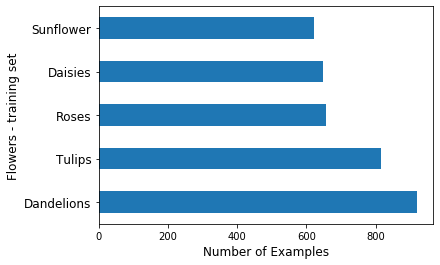

In [0]:
print(df['class'].value_counts())


ax = df['class'].value_counts().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("Flowers - training set", fontsize=12)
ax.set_yticklabels(['Dandelions','Tulips','Roses','Daisies','Sunflower'], rotation=0, fontsize=12)
plt.show()

In [14]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 5

df.shape

(3664, 2)

In [0]:
# Split into train and validation sets
# train_set_percentage = .9

# # Make the training set
# train_filenames_list = filenames_list[:int(len(filenames_list)*train_set_percentage)]
# train_labels_list = labels_list[:int(len(filenames_list)*train_set_percentage)]

# # Make the validation set
# val_filenames_list = filenames_list[int(len(filenames_list)*train_set_percentage):]
# val_labels_list = labels_list[int(len(filenames_list)*train_set_percentage):]


## Make the pipeline for loading and resizing the images

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
#img_rows, img_cols = 299,299
img_rows, img_cols = 224,224

def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize_images(image_decoded, [img_rows, img_cols])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
# A vector of filenames - from a list
filenames = tf.constant(train_filenames_list)

# Labels that match the training files - from a list
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

## Assembling the Data pipeline using tf.data

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(32)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(100)
valid_dataset = valid_dataset.batch(32)

## Create the network




In [17]:
import tensorflow as tf
# create the base pre-trained model
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 2s 0us/step


In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
len(base_model.layers)

19

In [20]:
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x) #Adaptive Pooling

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

#x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 2 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
len(model.layers)

22

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    #print(layer.name)
    layer.trainable = False

for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False
global_average_pooling2d
True
dense
True
dense_1
True


In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# If you use InceptionV3 you must freeze the weights layers but not batchnorm layers: un comment the following

# Freeze the InceptionV3 layers except the BatchNorm
# for layer in base_model.layers:
#     if 'batch' in layer.name:
#       print(layer.name)
#       layer.trainable = True
#     else:
#       layer.trainable = False 

## Create a simple head for the model that we can train

In [0]:
# Creating the model that we will train
# model = Model(inputs=base_model.input, outputs=predictions)

## Select an Optimizer 

In [0]:
# creates the optimizer using a tensorFlow optimizer with lr setting the Learning Rate

# tf.keras optimizer
opt = optimizers.Adam(lr)

# We could use a TensorFlow Optimizer but they can't save the weight as a whole
# opt = tf.train.AdamOptimizer(lr)

## Compile the model

In [0]:
# compile the model 

model.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['accuracy'])

## Call backs

In [0]:
!mkdir checkpoints


checkpoint = M odelCheckpoint('./checkpoints/weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, save_best_only=True, mode='auto')

Steps = 3888 / batch_size

In [0]:
train_steps = 100
val_steps = 100
epochs = 10

## Fit the model

we pass in:
- The training set
- the steps for how many times we want to sample a batch to be one epoch
- number of epochs
- validation set
- number of steps for validation

In [32]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[checkpoint])

Train on 100 steps, validate on 100 steps
Epoch 1/10
 99/100 [============================>.] - ETA: 0s - loss: 1.0923 - acc: 0.7727
Epoch 00001: val_loss improved from inf to 0.57967, saving model to ./checkpoints/weights_01_0.85.hdf5
100/100 [==============================] - 56s 556ms/step - loss: 1.0856 - acc: 0.7734 - val_loss: 0.5797 - val_acc: 0.8519
Epoch 2/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3306 - acc: 0.8984
Epoch 00002: val_loss did not improve from 0.57967
100/100 [==============================] - 48s 476ms/step - loss: 0.3288 - acc: 0.8988 - val_loss: 0.6026 - val_acc: 0.8487
Epoch 3/10
 99/100 [============================>.] - ETA: 0s - loss: 0.1718 - acc: 0.9416
Epoch 00003: val_loss improved from 0.57967 to 0.46763, saving model to ./checkpoints/weights_03_0.88.hdf5
100/100 [==============================] - 48s 479ms/step - loss: 0.1709 - acc: 0.9419 - val_loss: 0.4676 - val_acc: 0.8831
Epoch 4/10
 99/100 [============================>.] 

In [0]:
!ls checkpoints

weights_01_0.86.hdf5  weights_03_0.87.hdf5
weights_02_0.84.hdf5  weights_07_0.88.hdf5


In [33]:
metrics = model.evaluate(valid_dataset,steps=50)
print("model accuracy:",metrics[1])

50/50 [==============================] - 12s 240ms/step - loss: 0.4499 - acc: 0.8863
model accuracy: 0.88625


In [0]:
model.load_weights('./checkpoints/weights_07_0.88.hdf5')

## Make some predictions


In [39]:
preds = model.predict(valid_dataset,steps=10)
preds = preds.argmax(axis=-1)

preds.shape

(320,)

In [0]:
test_labels = val_labels_list[0:320]

In [0]:
len(test_labels)

320

## Make a Confusion Matrix


In [0]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(test_labels,preds)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Normalized confusion matrix
[[0.9245283  0.03773585 0.         0.03773585 0.        ]
 [0.0617284  0.90123457 0.         0.03703704 0.        ]
 [0.05263158 0.01754386 0.80701754 0.01754386 0.10526316]
 [0.01754386 0.01754386 0.         0.92982456 0.03508772]
 [0.01388889 0.01388889 0.08333333 0.06944444 0.81944444]]


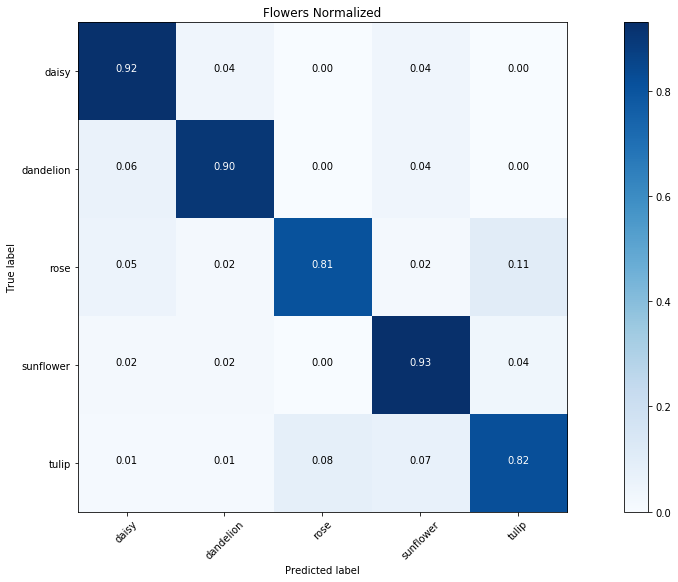

In [42]:
cm_plot_labels = names

# # Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Flowers Normalized')

plt.show()

## Save the Model and weights 

In [0]:
model.save('flowers.h5')


In [0]:
model.save_weights('flowers_weights.h5', save_format='h5')

In [0]:
!ls

checkpoints  flowers		 gdrive.py  __pycache__
datalab      flowers_weights.h5  __MACOSX   sutils.py


In [0]:
model.save_weights('./flowers_tf')

In [0]:
!ls

checkpoint   flowers			     flowers_weights.h5  __pycache__
checkpoints  flowers_tf.data-00000-of-00001  gdrive.py		 sutils.py
datalab      flowers_tf.index		     __MACOSX


In [0]:
# model = load_model('flowers.h5')

## Make some predictions

In [43]:
!wget -qq https://www.dropbox.com/s/iupwkbumwldk9es/testing_flowers.zip
  
  
!unzip -qq testing_flowers.zip
!rm testing_flowers.zip



!ls

checkpoints  gdrive.py	sample_data  testing_flowers
flowers      __MACOSX	sutils.py


In [0]:
!ls testing_flowers

daisy01.jpg  dandelion01.jpg  rose01.jpg  sunflower01.jpg  tulip01.jpg
daisy02.jpg  dandelion02.jpg  rose02.jpg  sunflower02.jpg  tulip02.jpg
daisy03.jpg  dandelion03.jpg  rose03.jpg  sunflower03.jpg  tulip03.jpg


In [0]:
image_path = './testing_flowers/'

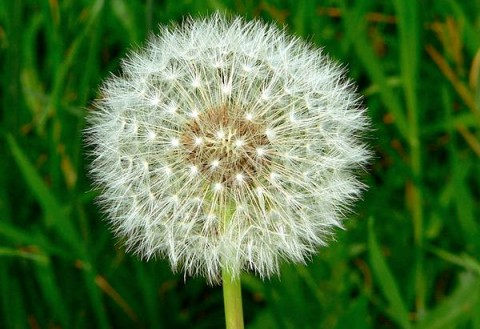

In [0]:
from IPython.display import Image

image_name = 'dandelion03.jpg'
Image(image_path+image_name)

In [0]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = os.path.join(image_path, image_name)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [0]:
pred = model.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

Predicted: [[2.1609355e-13 1.0000000e+00 3.1048988e-21 4.0545206e-10 9.8386240e-15]]
1


In [0]:
result= np.argmax(pred)
if result==0:
    print("Its a Daisy")
elif result==1:
    print("Its a Dandelion")
elif result==2:
    print("Its a Rose")
elif result==3:
    print("Its a Sunflower")
elif result==4:
    print("Its a Tulip")

Its a Dandelion


In [0]:
names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

## Saving the model and weights back to local machine

In [0]:
# Downloading from colab to local machine

from google.colab import files

files.download('flowers.h5')  

FileNotFoundError: ignored

In [0]:
files.download('flowers_weights.h5') 

## What to do from here

- Data Augmentation
- Try different networks
- convert to a TF Estimators for serving 



In [0]:
estimator = tf.keras.estimator.model_to_estimator(model)

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsgob4ng3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0dc977e630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### If you need to kill the VM and restart Colab with a new machine

In [0]:
!kill -9 -1